# 房價預測



- 來源：[Kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/overview)
- 目標：SalePrice 房價（美金）


In [5]:
import numpy as np  
import pandas as pd  
import matplotlib.pyplot as plt 
import seaborn as sns
import random
import os
from scipy import stats
from scipy.stats import norm, skew 

plt.rc("font",family="SimHei",size="15") 

%matplotlib inline 

In [6]:
df_train = pd.read_csv("data2/train.csv")
df_test = pd.read_csv('data2/test.csv')

df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [7]:
df_train.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [8]:

df_train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

findfont: Font family ['SimHei'] not found. Falling back to DejaVu Sans.


<Figure size 1600x500 with 0 Axes>

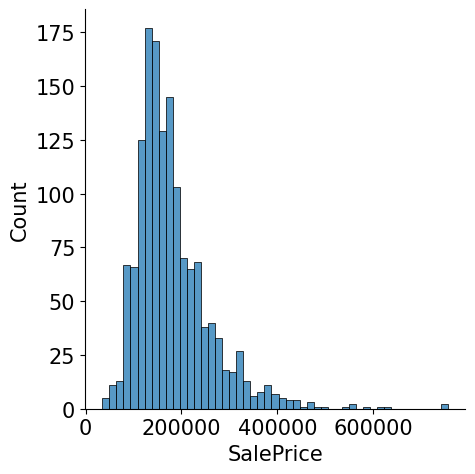

In [9]:
plt.figure(figsize=(16, 5))
sns.displot(df_train['SalePrice'],kde=False)  

In [10]:
print("Skewness: %f" % df_train['SalePrice'].skew())
print("Kurtosis: %f" % df_train['SalePrice'].kurt())

Skewness: 1.882876
Kurtosis: 6.536282


<AxesSubplot:>

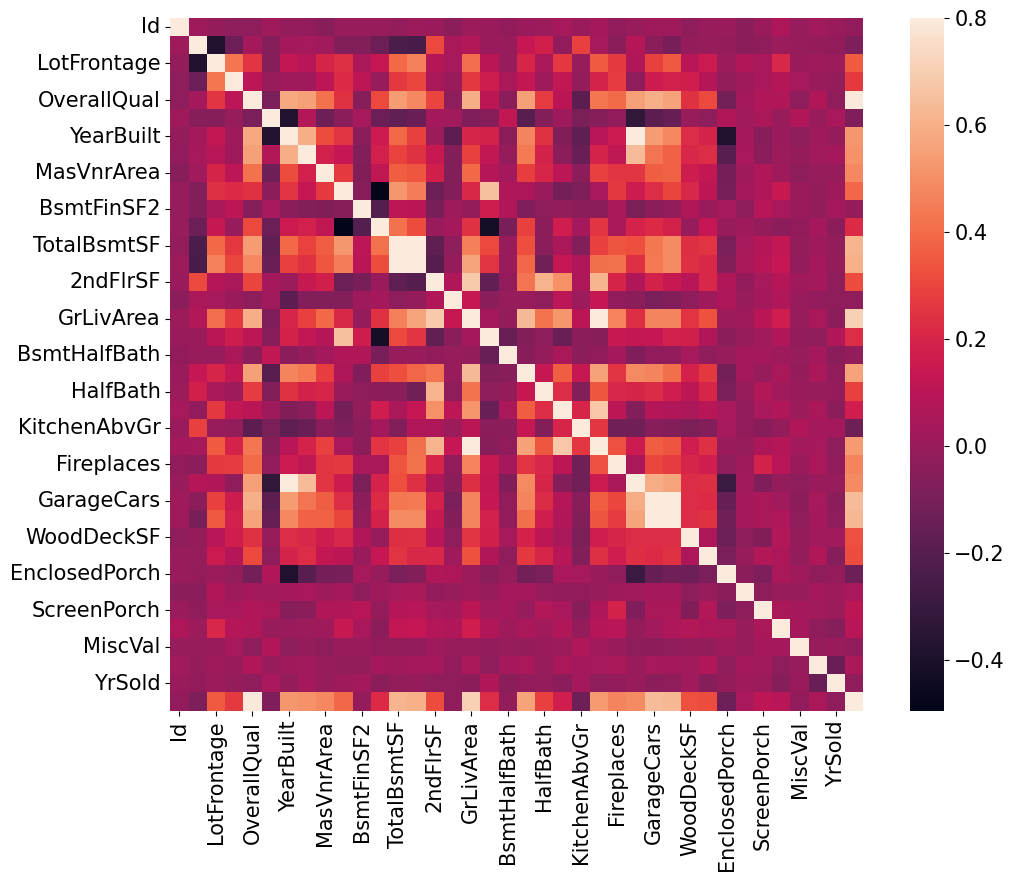

In [11]:
corrmat = df_train.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True)

In [74]:
print(df_train["SalePrice"])

0       208500
1       181500
2       223500
3       140000
4       250000
         ...  
1455    175000
1456    210000
1457    266500
1458    142125
1459    147500
Name: SalePrice, Length: 1460, dtype: int64


# Impute and Preprocessing

In [12]:
def missing(data,num=10):
    null_data = data.isnull().sum().sort_values(ascending=False)
    percent_1 = data.isnull().sum()/data.isnull().count()
    missing_data = pd.concat([null_data,percent_1.apply(lambda x: format(x, '.2%'))],axis=1,keys=['total missing','missing percentage'])
    print(missing_data.head(num))

missing(df_train, 15)


              total missing missing percentage
PoolQC                 1453             99.52%
MiscFeature            1406             96.30%
Alley                  1369             93.77%
Fence                  1179             80.75%
FireplaceQu             690             47.26%
LotFrontage             259             17.74%
GarageYrBlt              81              5.55%
GarageCond               81              5.55%
GarageType               81              5.55%
GarageFinish             81              5.55%
GarageQual               81              5.55%
BsmtFinType2             38              2.60%
BsmtExposure             38              2.60%
BsmtQual                 37              2.53%
BsmtCond                 37              2.53%


In [13]:
df_train.drop(["PoolQC","MiscFeature","Alley","Fence"], axis=1, inplace=True)
missing(df_train,5) 


              total missing missing percentage
FireplaceQu             690             47.26%
LotFrontage             259             17.74%
GarageType               81              5.55%
GarageYrBlt              81              5.55%
GarageFinish             81              5.55%


In [14]:
numeric = df_train.dtypes[df_train.dtypes == "int64"]
object_ = df_train.dtypes[df_train.dtypes == "object"]

In [15]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 77 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

df_train['LotShape'] = df_train['LotShape'].replace(['Reg', 'IR1', 'IR2', 'IR3'], [0,1,2,3])
df_train['LandContour'] = df_train['LandContour'].replace( ['Lvl', 'Bnk', 'Low', 'HLS'],[0,1,-1,2])
df_train['Street'] = df_train['Street'].replace(['Pave', 'Grvl'], [0,1])
df_train['MSZoning'] = df_train['MSZoning'].replace(['RL', 'RM', 'C (all)', 'FV', 'RH'], [2,1,0,3,1])
df_train.drop("Utilities",axis = 1, inplace = True)
df_train['LotConfig'] = df_train['LotConfig'].replace(['Inside', 'FR2', 'Corner', 'CulDSac', 'FR3'], [0,0,0,1,1])
df_train['MSZoning'] = df_train['MSZoning'].replace(['RL', 'RM', 'C (all)', 'FV', 'RH'], [2,1,0,3,1])

###太多了寫不完

In [16]:
def check_Cate_mean_price(col):
    ele = list(df_train[col].unique())
    print(df_train[col] .value_counts())
    print()
    for j in ele :
        print(j,np.mean([df_train["SalePrice"][i] for i in range(1460) if df_train[col][i] == j]))
    
    return ele


col = "LotConfig"
check_Cate_mean_price(col)


Inside     1052
Corner      263
CulDSac      94
FR2          47
FR3           4
Name: LotConfig, dtype: int64

Inside 176938.0475285171
FR2 177934.5744680851
Corner 181623.4258555133
CulDSac 223854.6170212766
FR3 208475.0


['Inside', 'FR2', 'Corner', 'CulDSac', 'FR3']

In [17]:
df_train['MSSubClass'] = df_train['MSSubClass'].apply(str)
df_train['OverallCond'] = df_train['OverallCond'].astype(str)
df_train['YrSold'] = df_train['YrSold'].astype(str)
df_train['MoSold'] = df_train['MoSold'].astype(str)

In [18]:
from sklearn.preprocessing import LabelEncoder
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond',
        'ExterQual', 'ExterCond','HeatingQC',  'KitchenQual', 'BsmtFinType1',
        'BsmtFinType2', 'Functional',  'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street',  'CentralAir', 'MSSubClass', 'OverallCond',
        'YrSold', 'MoSold')

for c in cols:
    lbl = LabelEncoder()
    lbl.fit(list(df_train[c].values))
    df_train[c] = lbl.transform(list(df_train[c].values)) 

In [19]:
df_train['TotalSF'] = df_train['TotalBsmtSF'] + df_train['1stFlrSF'] + df_train['2ndFlrSF']

In [20]:
df_train = pd.get_dummies(df_train)
print(df_train.shape)
df_train.head()

(1460, 216)


,Id,MSSubClass,LotFrontage,LotArea,Street,LotShape,LandSlope,OverallQual,OverallCond,YearBuilt,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1,9,65.0,8450,1,3,0,7,4,2003,...,0,0,0,1,0,0,0,0,1,0
1,2,4,80.0,9600,1,3,0,6,7,1976,...,0,0,0,1,0,0,0,0,1,0
2,3,9,68.0,11250,1,0,0,7,4,2001,...,0,0,0,1,0,0,0,0,1,0
3,4,10,60.0,9550,1,0,0,7,4,1915,...,0,0,0,1,1,0,0,0,0,0
4,5,9,84.0,14260,1,0,0,8,4,2000,...,0,0,0,1,0,0,0,0,1,0


In [21]:
df_train.drop("Id",axis=1,inplace=True)

### MICE

In [98]:
from sklearn.model_selection import train_test_split
X = df_train.drop("SalePrice" , axis=1)
y = df_train["SalePrice"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
print(y_train)

615     137500
613     147000
1303    232000
486     156000
561     170000
         ...  
1095    176432
1130    135000
1294    115000
860     189950
1126    174000
Name: SalePrice, Length: 978, dtype: int64


In [99]:
names = list(X_train.columns)
len(names)

214

In [100]:
from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import IterativeImputer

mice = IterativeImputer(random_state=42)

X_train = pd.DataFrame(mice.fit_transform(X_train))
X_test = pd.DataFrame(mice.transform(X_test))

In [101]:
missing(X_train, 5)
missing(X_test, 5)

     total missing missing percentage
0                0              0.00%
134              0              0.00%
136              0              0.00%
137              0              0.00%
138              0              0.00%
     total missing missing percentage
0                0              0.00%
134              0              0.00%
136              0              0.00%
137              0              0.00%
138              0              0.00%


In [102]:
from sklearn.preprocessing import RobustScaler 

scaler = RobustScaler ()

X_train = pd.DataFrame(scaler .fit_transform(X_train))
X_test = pd.DataFrame(scaler .transform(X_test))

In [111]:
X_train.columns = names
X_test.columns = names

y_train.index

X_train['SalePrice'] = y_train.reset_index(drop = True)
X_test['SalePrice'] = y_test.reset_index(drop = True)

X_train.to_csv("data2/X_train.csv", quoting=False,index=False)
X_test.to_csv("data2/X_test.csv", quoting=False,index=False)

In [115]:
X_train.head()

,MSSubClass,LotFrontage,LotArea,Street,LotShape,LandSlope,OverallQual,OverallCond,YearBuilt,YearRemodAdd,...,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,SalePrice
0,1.8,0.454545,-0.191453,0.0,0.0,0.0,0.0,2.0,-0.187500,-0.815789,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-1.0,0.0,137500
1,0.0,0.000000,-0.289205,0.0,0.0,0.0,-0.5,0.0,0.729167,0.342105,...,1.0,0.0,-1.0,0.0,0.0,0.0,0.0,-1.0,1.0,147000
2,0.0,0.136364,-0.218961,0.0,0.0,0.0,0.5,0.0,0.687500,0.289474,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,232000
3,0.0,0.409091,0.174260,0.0,0.0,0.0,-0.5,2.0,-0.145833,-0.763158,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,156000
4,0.0,0.318182,0.105735,0.0,0.0,1.0,-0.5,0.0,0.041667,-0.500000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,170000


# Model

In [116]:
from sklearn.pipeline import make_pipeline #pipeline
from sklearn.preprocessing import RobustScaler 
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone #自定义类的API
from sklearn.model_selection import KFold, cross_val_score, train_test_split #交叉验证
from sklearn.metrics import mean_squared_error 
import torch
from torch import nn
# import lightgbm as lgb #lightGBM
train = pd.read_csv("data2/X_train.csv")
test = pd.read_csv("data2/X_test.csv")

X_train = train.drop("SalePrice",axis=1)
X_test = test.drop("SalePrice",axis=1)

y_train = train["SalePrice"]
y_test= test["SalePrice"]

In [117]:
X_train.head()

,MSSubClass,LotFrontage,LotArea,Street,LotShape,LandSlope,OverallQual,OverallCond,YearBuilt,YearRemodAdd,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1.8,0.454545,-0.191453,0.0,0.0,0.0,0.0,2.0,-0.187500,-0.815789,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-1.0,0.0
1,0.0,0.000000,-0.289205,0.0,0.0,0.0,-0.5,0.0,0.729167,0.342105,...,0.0,1.0,0.0,-1.0,0.0,0.0,0.0,0.0,-1.0,1.0
2,0.0,0.136364,-0.218961,0.0,0.0,0.0,0.5,0.0,0.687500,0.289474,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.409091,0.174260,0.0,0.0,0.0,-0.5,2.0,-0.145833,-0.763158,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.318182,0.105735,0.0,0.0,1.0,-0.5,0.0,0.041667,-0.500000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [118]:
x_in = torch.Tensor(X_train.values)
y_in = torch.Tensor(y_train.values)



In [239]:
#Xavier initialization
def init_weights(m,k=1,gain = 100):
    for i in m:
        if isinstance(i, nn.Linear):
            w = torch.empty(i.in_features, i.out_features)
            torch.nn.init.xavier_normal(i.weight, gain = gain)
            i.bias.data.fill_(k)

#l2 reguliaztion
def l2_loss(model, lambda0 = 0.001):
    paras = []
    for para in model.parameters():
        paras.append(para.view(-1))
    return lambda0* torch.square(torch.cat(paras)).sum()

## Best Model: 11 hidden  with RELU act

### 1. Change into LG

In [269]:
#scaling y
scaler = RobustScaler()
y_in_s = torch.Tensor(scaler.fit_transform(y_train.values.reshape(-1,1)))
y_val_s = torch.Tensor(scaler.transform(y_test.values.reshape(-1,1)))

y_in = torch.Tensor(y_train.values)
y_val = torch.Tensor(y_test.values)
#inverse_transform(X)

In [297]:
device = torch.device('cpu')
N, D_in,  D_out = 978, 214, 1
H = [5,8,11]

model_11 = torch.nn.Sequential(
    torch.nn.Linear(D_in, 150),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(150, 100),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(100, 50),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(50, 20),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(20, H[2]),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(H[2], D_out)
    
)

init_weights(model_11,0.1,1)
model_11(x_in)

C:\Users\ku\AppData\Local\Temp\ipykernel_20272\2962192691.py:6: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  torch.nn.init.xavier_normal(i.weight, gain = gain)


tensor([[ 0.6967],
        [ 0.4166],
        [ 0.5213],
        [ 0.5445],
        [ 1.6027],
        [ 0.6315],
        [ 2.4362],
        [ 0.7247],
        [ 0.4730],
        [ 4.0928],
        [ 0.5746],
        [ 0.5645],
        [ 0.7070],
        [ 0.5979],
        [ 0.4357],
        [ 4.4948],
        [ 0.4237],
        [ 0.6658],
        [ 0.7125],
        [ 0.5157],
        [ 0.4528],
        [ 1.4230],
        [ 0.4218],
        [ 0.5562],
        [ 2.0949],
        [ 1.9978],
        [ 0.4567],
        [ 5.3765],
        [ 0.5631],
        [17.2976],
        [ 0.4247],
        [ 0.5859],
        [ 7.0194],
        [ 0.6686],
        [ 0.4754],
        [ 0.6243],
        [ 0.4398],
        [ 5.3372],
        [ 0.5248],
        [ 0.5629],
        [ 0.6069],
        [ 0.6578],
        [ 6.0030],
        [ 0.5501],
        [ 0.6009],
        [ 0.7334],
        [ 0.5582],
        [ 0.6051],
        [ 0.5966],
        [ 0.5532],
        [ 0.4019],
        [ 6.4603],
        [ 3.

In [299]:
epochs = 3000
l_r = 1e-3
optimizer = torch.optim.Adam(model_11.parameters(),lr= l_r,)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,300)

while True:
    #batch_index = random.sample( [i for i in range(978)], 978//10)

    y_pred = model_11(x_in)
    loss_in = nn.functional.mse_loss(y_pred,y_in_s)

    y_pred_val = model_11(x_val)
    loss_out = nn.functional.mse_loss(y_pred_val,y_val_s)
    l2 = l2_loss(model_11)

    loss_out +=l2
    loss_in+=l2
    print(loss_in.item(),loss_out.item())


    optimizer.zero_grad()
    loss_in.backward()
    optimizer.step()

    if loss_in < 0.05: break
    lr_scheduler.step()

0.1278875768184662 0.41641995310783386
2.007660150527954 5.694540500640869
0.37512606382369995 1.0833252668380737
0.36529621481895447 0.9490789175033569
0.9206058979034424 2.665416717529297
0.6556747555732727 2.0843136310577393
0.2869630455970764 0.8600029945373535
0.164897620677948 0.37076491117477417


0.2830639183521271 0.7124733328819275
0.4093310236930847 1.1008975505828857
0.4128696918487549 1.1082428693771362
0.30712124705314636 0.7910243272781372
0.18870587646961212 0.4607904851436615
0.14314448833465576 0.37208300828933716
0.1814901977777481 0.5346298217773438
0.24480782449245453 0.7473483681678772
0.2678758502006531 0.8054602742195129
0.23503971099853516 0.6722173690795898
0.1789756417274475 0.46586349606513977
0.14154711365699768 0.33260780572891235
0.14276209473609924 0.335324764251709
0.16972246766090393 0.42451542615890503
0.1925623118877411 0.49740374088287354
0.1909782588481903 0.4894549548625946
0.16714131832122803 0.4143872857093811
0.139438658952713 0.340018093585968
0.12517879903316498 0.3178972005844116
0.1302572786808014 0.35944676399230957
0.1452050805091858 0.4247836470603943
0.15430131554603577 0.4591328203678131
0.14926673471927643 0.43900543451309204
0.13441872596740723 0.3838256597518921
0.12118242681026459 0.334392786026001
0.11755751073360443 0.31875872611

In [300]:
y_pred_val_s = model_11(x_val)
loss1 = nn.functional.mse_loss(y_pred_val_s,y_val_s)
print(loss1 )


y_pred_val = torch.Tensor(scaler.inverse_transform(y_pred_val_s.detach().numpy()))
loss2 = nn.functional.mse_loss(y_pred_val,y_val)
print(loss2)

tensor(0.2018, grad_fn=<MseLossBackward0>)
tensor(1.2882e+10)


C:\Users\ku\AppData\Local\Temp\ipykernel_20272\1216723949.py:7: UserWarning: Using a target size (torch.Size([482])) that is different to the input size (torch.Size([482, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss2 = nn.functional.mse_loss(y_pred_val,y_val)


In [301]:
random.seed ( 10 )
random_draw = random.sample( [i for i in range(482)], 482//10)
[ [y_pred_val[i].item(),y_val[i].item()] for i in random_draw]

[[144236.859375, 145000.0],
 [190358.375, 183500.0],
 [131818.21875, 126000.0],
 [174535.40625, 176000.0],
 [157403.4375, 175000.0],
 [144029.875, 146000.0],
 [171368.078125, 156500.0],
 [201856.5, 195400.0],
 [125191.9140625, 128500.0],
 [166860.15625, 160000.0],
 [208521.921875, 270000.0],
 [172740.9375, 178000.0],
 [156561.890625, 146000.0],
 [316835.875, 423000.0],
 [106498.78125, 113000.0],
 [141785.578125, 135000.0],
 [164254.9375, 153500.0],
 [171798.234375, 192140.0],
 [300821.5, 276000.0],
 [324380.4375, 310000.0],
 [70364.53125, 79500.0],
 [233521.15625, 168000.0],
 [256132.59375, 255000.0],
 [174349.421875, 173500.0],
 [264049.21875, 262500.0],
 [206241.15625, 215200.0],
 [122618.4765625, 134000.0],
 [212876.40625, 217000.0],
 [89691.5859375, 55993.0],
 [176136.25, 225000.0],
 [134095.9375, 123000.0],
 [177853.65625, 175000.0],
 [354143.8125, 310000.0],
 [67624.9296875, 35311.0],
 [115621.0078125, 135000.0],
 [194474.140625, 155835.0],
 [365996.0625, 380000.0],
 [140829.2031

### 2. Change into LG EB

In [307]:
#scaling y
scaler = RobustScaler()
y_in_s = torch.Tensor(scaler.fit_transform(y_train.values.reshape(-1,1)))
y_val_s = torch.Tensor(scaler.transform(y_test.values.reshape(-1,1)))

y_in = torch.Tensor(y_train.values)
y_val = torch.Tensor(y_test.values)
#inverse_transform(X)
device = torch.device('cpu')
N, D_in,  D_out = 978, 214, 1
H = [5,8,11]

model_11 = torch.nn.Sequential(
    torch.nn.Linear(D_in, 150),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(150, 100),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(100, 50),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(50, 20),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(20, H[2]),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(H[2], D_out)
    
)

init_weights(model_11,0.1,1)
model_11(x_in)
epochs = 3000
l_r = 1e-3
optimizer = torch.optim.Adam(model_11.parameters(),lr= l_r,)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,300)

for i in range(epochs):
    #batch_index = random.sample( [i for i in range(978)], 978//10)

    y_pred = model_11(x_in)
    loss_in = nn.functional.mse_loss(y_pred,y_in_s)

    y_pred_val = model_11(x_val)
    loss_out = nn.functional.mse_loss(y_pred_val,y_val_s)
    l2 = l2_loss(model_11)

    loss_out +=l2
    loss_in+=l2
    print(loss_in.item(),loss_out.item())


    optimizer.zero_grad()
    loss_in.backward()
    optimizer.step()

    if loss_in < 0.05: break
    lr_scheduler.step()


C:\Users\ku\AppData\Local\Temp\ipykernel_20272\2962192691.py:6: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  torch.nn.init.xavier_normal(i.weight, gain = gain)


25.18143081665039 94.98075866699219
22.27618980407715 55.23288345336914
4.894864082336426 8.333916664123535
2.291703701019287 2.9884719848632812
3.593869924545288 8.431142807006836
3.345409870147705 9.959214210510254
2.3691859245300293 6.651656627655029
1.8235712051391602 2.9971251487731934
1.7149078845977783 2.1442267894744873
1.9986711740493774 3.721510171890259
1.9572958946228027 3.8293535709381104
1.5392264127731323 2.3368897438049316
1.3186321258544922 1.5339770317077637
1.4536025524139404 2.2281041145324707
1.3357112407684326 2.1076064109802246
1.1860668659210205 1.8498295545578003
1.1175634860992432 1.7450674772262573
1.0417423248291016 1.5116734504699707
0.954474687576294 1.2895718812942505
0.8895820379257202 1.1956883668899536
0.8584697246551514 1.2231069803237915
0.8561539053916931 1.2580926418304443
0.862185001373291 1.2570407390594482
0.845771312713623 1.2133582830429077
0.8062849044799805 1.124107837677002
0.7665952444076538 1.0334656238555908
0.7455915212631226 0.98240482

In [308]:
y_pred_val_s = model_11(x_val)
loss1 = nn.functional.mse_loss(y_pred_val_s,y_val_s)
print(loss1 )


y_pred_val = torch.Tensor(scaler.inverse_transform(y_pred_val_s.detach().numpy()))
loss2 = nn.functional.mse_loss(y_pred_val,y_val)
print(loss2)


tensor(0.3388, grad_fn=<MseLossBackward0>)
tensor(1.3435e+10)


C:\Users\ku\AppData\Local\Temp\ipykernel_20272\3548603333.py:7: UserWarning: Using a target size (torch.Size([482])) that is different to the input size (torch.Size([482, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss2 = nn.functional.mse_loss(y_pred_val,y_val)


In [309]:
random.seed ( 10 )
random_draw = random.sample( [i for i in range(482)], 482//10)
[ [y_pred_val[i].item(),y_val[i].item()] for i in random_draw]

[[137332.40625, 145000.0],
 [193422.75, 183500.0],
 [120784.125, 126000.0],
 [179573.5625, 176000.0],
 [152921.6875, 175000.0],
 [149083.890625, 146000.0],
 [208119.65625, 156500.0],
 [190272.671875, 195400.0],
 [124643.3515625, 128500.0],
 [159942.359375, 160000.0],
 [202721.03125, 270000.0],
 [176394.6875, 178000.0],
 [159809.34375, 146000.0],
 [325517.6875, 423000.0],
 [98144.1953125, 113000.0],
 [134315.296875, 135000.0],
 [156919.734375, 153500.0],
 [177818.5, 192140.0],
 [314990.09375, 276000.0],
 [292739.75, 310000.0],
 [149887.703125, 79500.0],
 [239698.515625, 168000.0],
 [254492.703125, 255000.0],
 [176245.625, 173500.0],
 [270203.1875, 262500.0],
 [202938.5, 215200.0],
 [110831.0859375, 134000.0],
 [208524.125, 217000.0],
 [136841.3125, 55993.0],
 [165648.953125, 225000.0],
 [131535.75, 123000.0],
 [176298.203125, 175000.0],
 [363139.1875, 310000.0],
 [69532.84375, 35311.0],
 [129216.875, 135000.0],
 [181059.578125, 155835.0],
 [369545.3125, 380000.0],
 [124032.25, 136000.0]

## 資料來源:
[house-prices-advanced-regression-techniques](https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/data)
## 資料簡介:
### X 為 1460*75的房屋資料集，共有39個categorial variables，35個ordinal variables以及2個continuos variables。
##### Missing Rate
|              |total  missing | missing percentage | handling |
|--------------|---------|----------|------------|
| PoolQC       | 1453    | 99.52%   | drop       |
| MiscFeature  | 1406    | 96.30%   | drop       |
| Alley        | 1369    | 93.77%   | drop       |
| Fence        | 1179    | 80.75%   | drop       |
| FireplaceQu  | 690     | 47.26%   | Use IterativeImputer |
| LotFrontage  | 259     | 17.74%   | Use IterativeImputer |
| GarageYrBlt  | 81      | 5.55%    | Use IterativeImputer |
| GarageCond   | 81      | 5.55%    | Use IterativeImputer |
| GarageType   | 81      | 5.55%    | Use IterativeImputer | 
|             |      |  :    |  |
|             |      |  :    |  |
### y 為1460*1的房價，介於34900至755000之間，平均為180921.196，標準差為 79442.502883，稍微有點右偏，不符合常態假設。
### 因為kaggle 競賽的df_test沒有y，所以將df_train 以8:2 分成 train set和validation set。




## Conclusion
#### 這次一開始調了一堆參數增加了好幾層但最後結果都不太理想，後來發現一個問題是我Xavier函數沒寫好，幾乎等於沒做，補好之後發現生出來的數字可以調整scale。另一點模型表現增加最多的地方是對y做了scale，用robust scaler 調整並用來訓練，訓練完後再把test 預測出來的結果用inverse_transform轉換回去。

## hidden nodes:
#### 從2 layer 11個nodes改成 6 layer 214*150*100*50*20*11*1
## initial weight:
#### 做了 Xavier，但有做沒做最後都會收斂到差不多的點
## Activation:
#### 主要用RELU ，tanh 不知道為什麼所有的點都預測一樣，可能是因為只有一層，Activation function 的種類影響蠻大的
## Loss:
#### MSE + l2 regulization 加上l2後好像沒差多少.....
## Optmizer epoch
#### Adam 真的比 SGD快多了，Adam 大約200左右就收斂，SGD跑到3000 loss都還在降
## learning_rate
#### 如果用RELU 大概要設在10^-2 左右，tanh的話要設到10^2 loss才會跑。RELU加上cosine 後下降更慢但比較不會出現預測結果都在180000上下的問題
## Ensembles
#### 因為看這幾個模型結果都差不多所以沒做，可能要用不同initial weight的模型來做ensembles
## Batch Normalization
####最後有點趕所以沒做
